### imports and a couple useful functions:

In [ ]:
from __future__ import print_function, division

import pandas as pd
import seaborn as sns
import numpy as np
from scipy import interp

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)

from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from tqdm import tqdm
from glob import glob
import datetime
import os, sys
from itertools import cycle

pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

from collections import OrderedDict

## some useful team data in here (converters from short to long):
from basketball_reference_web_scraper import data

years = np.arange(1950, 2019)

## custom printing for my Keras training:
class PrintCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 25 == 0:
#             print(logs.keys())
            print("epoch {}:  loss = {:.2f}, accuracy = {:.2f}".format(
                epoch, logs['loss'], logs['acc']))
    def on_train_begin(self, logs={}):
        print("Beginning training...")
    
    def on_train_end(self, logs):
        print("Training completed")

early_stopper = keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
nan_stopper = keras.callbacks.TerminateOnNaN()

def find_player_id(player_name, df):
    possible_pids = np.unique(df.index[df['player_name'] == player_name])
    if possible_pids.size == 1:
        return possible_pids[0]
    elif possible_pids.size > 1:
        print("Many options; returning most average points:")
        vals = []
        for pid in possible_pids:
            rows = df.loc[df.index==pid]
            mean_points = np.average(rows['points'])
            vals.append(mean_points)
            print(f'\t{pid} with an average point/year of {mean_points}'.format(
                row['PlayerID'], row['CareerValue']))
        return possible_pids[np.argmax(vals)]
    else:
        print("No exact name matches... possible names:")
        from fuzzywuzzy import process
        matches = process.extract(player_name, np.unique(df['player_name'].values), limit=10)
        for poss in matches:
            print("\t",poss[0])
        print("Returning best match, but maybe incorrect...")
        return find_player_id(matches[0][0], df)
    
class CyclicList(list):
    def __getitem__(self, index):
        return super().__getitem__(index%len(self))

### functions that implement recommendations on network size:

In [2]:
def recommended_max_hidden_neurons_hobbs(training_sample_size, 
                                   num_input_neurons, 
                                   num_output_neurons,
                                  alpha=2.5):
    """
    recommend the max number of hidden neurons based on I/O & sample size
    
    this recommendation is taken from the second answer (from @hobbs) on
    stackexchange here:  

    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    """
    
    bottom = alpha * (num_input_neurons + num_output_neurons)
    return training_sample_size/bottom

def recommend_max_hidden_neurons_heaton(num_input_neurons,
                                       num_output_neurons):
    """
    following the third answer, from @jj_, who quotes Heaton,
    we have three rules of thumb:

    * The number of hidden neurons should be between the size 
      of the input layer and the size of the output layer.
    
    * The number of hidden neurons should be 2/3 the size of 
      the input layer, plus the size of the output layer.
    
    * The number of hidden neurons should be less than twice 
      the size of the input layer.    
    """
    
    ## rule one:
    max_size = max([num_input_neurons, num_output_neurons])
    min_size = min([num_input_neurons, num_output_neurons])
    print(f"\tRule one recommends {min_size} - {max_size}")
    
    ## rule two:
    size = np.rint(2*num_input_neurons/3) + num_output_neurons
    print(f"\tRule two recommends {size}", end='')
    if min_size < size < max_size:
        print(", which also satisfies rule 1")
    else:
        print(", which is in conflict with rule 1")
    
    ## rule three:
    max_size_two = 2*num_input_neurons
    print(f"\tRule three recommends no more than {2*max_size_two}")

### extract test/training/validate and make recommendations:

In [3]:
def build_training_dataframe(yearly_df, player_df, 
                             training_columns, target_columns, 
                             years_to_train_on=2, 
                             min_career_length=2, 
                             frac_train=0.75, 
                             frac_of_test_as_validate=0.5,
                             sort_before_splitting=True,
                             split_randomly=True,
                             drop_pre_1973=True,
                             drop_nans=True):
    
    assert True not in [tc in training_columns for tc in target_columns]
    min_career_length = max(min_career_length, years_to_train_on)
    
    msk = player_df['career_length'] >= min_career_length
    if drop_pre_1973:
        msk = msk & player_df['rookie_end_year'] >= 1973
        
    max_rookie_year = 2019 - years_to_train_on
    msk = msk & player_df['rookie_end_year'] < max_rookie_year
    player_subset = player_df.loc[msk]
    
    input_data = []
    
    ## loop over players that meet my requirements
    for pid in player_subset.index:
        ## grab the rows correspoding to that player
        rows = yearly_df[yearly_df.index==pid]
        if len(rows) < min_career_length:
            continue
        
        ## create a dictionary for each player
        pdata = dict(player_id=pid)
        
        ## add the data for the first n years (where n = years_to_train_on) 
        ## of that players career to their dictionary
        for ii in range(years_to_train_on):
            for k in training_columns:
                pdata[k+f'.y{ii+1}'] = rows[k].iloc[ii]
                
        input_data.append(pdata)
    
    ## now turn that dictionary back into a dataframe
    input_data = pd.DataFrame(input_data)
    input_data.set_index('player_id', inplace=True)

    ## and pull the targets out of our original dataset
    target_data = player_subset[target_columns].copy()
    
    ## if we're training for multiple categories, then make sure to label 
    ## people that aren't in any category as "other" if necessary
    if len(target_columns) > 1 and not (target_data>0).any(axis=1).all():
        target_data['is_other'] = target_data.apply(lambda row:  1.0 if (row==0).all() else 0.0, axis=1)
        print(f"Labeling {np.count_nonzero(target_data['is_other'])} players as 'other'")
        target_columns.append('is_other')

    if sort_before_splitting or drop_nans:
        for target_column in target_data:
            input_data[target_column] = target_data[target_column]
        if sort_before_splitting:
            input_data.sort_values(target_columns[0], inplace=True)
        if drop_nans:
            input_data.dropna(axis=0, how='any', inplace=True)
        target_data = input_data[target_columns].copy()
        input_data.drop(target_columns, axis=1, inplace=True)
        
    total_sample_size = len(target_data)
    all_indices = np.arange(total_sample_size)

    if split_randomly:
        ntrain = int(np.ceil(frac_train*total_sample_size))
        ntest = int(np.ceil((1-frac_train)*total_sample_size*(1-frac_of_test_as_validate)))
        nvalidate = int(np.ceil((1-frac_train)*total_sample_size*frac_of_test_as_validate))

        while ntest + ntrain + nvalidate > total_sample_size:
            ntest -= 1        
        
        train_indices = np.random.choice(all_indices, size=ntrain, replace=False)
        all_indices = np.setdiff1d(all_indices, train_indices)
        
        test_indices = np.random.choice(all_indices, size=ntest, replace=False)
        all_indices = np.setdiff1d(all_indices, test_indices)
        
        validate_indices = np.array(all_indices, copy=True)
    else:
        tt_stride = int(2/(1-frac_train))
        
        test_indices = all_indices[tt_stride//2::tt_stride]
        validate_indices = test_indices + 1
        train_indices = np.setdiff1d(all_indices, np.concatenate((test_indices, validate_indices)))
        
        if frac_of_test_as_validate > 0.5:
            ## move some of the test to validate:
            n_nontrain = test_indices.size + validate_indices.size
            target_num_validate = n_nontrain*frac_of_test_as_validate
            to_move = target_num_validate - validate_indices.size
            
            print(f"Randomly moving {to_move} of {test_indices.size} players from test to validate")
            indices_to_move = np.random.choice(test_indices, size=to_move, replace=False)
            
            ## remove those indices from test:
            test_indices = np.setdiff1d(test_indices, indices_to_move)
            
            ## and add them to validate:
            validate_indices = np.concatenate((validate_indices, indices_to_move))
        elif frac_of_test_as_validate < 0.5:
            ## move some of the validate to test:
            n_nontrain = test_indices.size + validate_indices.size
            target_num_test = n_nontrain*(1-frac_of_test_as_validate)
            to_move = target_num_test - test_indices.size
            
            print(f"Randomly moving {to_move} of {validate_indices.size} players from validate to test")
            indices_to_move = np.random.choice(validate_indices, size=to_move, replace=False)
            
            ## remove those indices from validate:
            validate_indices = np.setdiff1d(validate_indices, indices_to_move)
            
            ## and add them to test:
            test_indices = np.concatenate((test_indices, indices_to_move))
            
    
    
    trainX = input_data.iloc[train_indices]
    trainY = target_data.iloc[train_indices]
    
    testX = input_data.iloc[test_indices]
    testY = target_data.iloc[test_indices]
    
    validateX = input_data.iloc[validate_indices]
    validateY = target_data.iloc[validate_indices]
    
    return trainX, trainY, testX, testY, validateX, validateY

In [4]:
def extract_and_recommend(yearly_df, player_df, training_columns, target_columns, **kwargs):
    trainX, trainY, testX, testY, validateX, validateY = build_training_dataframe(
        yearly_df, player_df, training_columns, target_columns, **kwargs)
    
    print(f"Training on {trainX.shape[1]} columns, so using that many input neurons")
    print(f"Predicting {trainY.shape[1]} column(s), so using that many output neurons")
    
    input_neurons = trainX.shape[1]
    output_neurons = trainY.shape[1]
    
    print("@hobbs recommends {} hidden neurons max".format(
        recommended_max_hidden_neurons_hobbs(len(trainX), input_neurons, output_neurons)))
    print("Heaton recommends:")
    recommend_max_hidden_neurons_heaton(input_neurons, output_neurons)
    
    return trainX, trainY, testX, testY, validateX, validateY

### Build and train an model, optionally with hidden layers

In [5]:
def build_and_train_classifier( trainX, trainY, 
                                testX, testY,
                                scale_inputs=True,
                                hidden_layers=None,
                                hidden_layer_neurons=None, hidden_layer_kwargs=dict(kernel_initializer='random_normal'),
                                dropout_every=None, dropout_rate=0.5,
                                clear=True, optimizer='adam', loss='categorical_crossentropy',
                                epochs=250, metrics=['accuracy'], shuffle=True, batch_size=None,
                                input_layer=None, input_layer_neurons=None, input_layer_kwargs=dict(),
                                output_layer=None, output_layer_neurons=None, output_layer_kwargs=dict(activation='softmax', kernel_initializer='random_normal')):

    if clear:
        print("Clearing TensorFlow graph")
        keras.backend.clear_session()
        
    if len(trainY.shape) > 1 and trainY.shape[1] == 1 and loss == 'categorical_crossentropy':
        print("Switching to binary_crossentropy because only one category")
        loss = 'binary_crossentropy'
        
    if scale_inputs:
        trainX = scaler.fit_transform(trainX)
        testX = scaler.fit_transform(testX)
    
    model = keras.Sequential()
    
    ## add our input layer:
    if input_layer is not None:
        model.add(input_layer)
    else:
        if input_layer_neurons is None:  input_layer_neurons = 2 * trainX.shape[1]
        model.add(keras.layers.Dense(input_layer_neurons, input_shape=(trainX.shape[1],), **input_layer_kwargs))

    ## add any hidden layers
    if hidden_layers is not None:
        ## did we pass in pre-built layers?
        for layer in hidden_layers:
            model.add(layer)
    else:
        for ii, (neurons, kwargs) in enumerate(zip(hidden_layer_neurons, hidden_layer_kwargs)):
            ## otherwise, assume all are dense
            ## but add a dropout layer in between some fraction of the layers
            if dropout_every is not None and ii > 0 and ii % dropout_every == 0:
                model.add(keras.layers.Dropout(dropout_rate))
            model.add(keras.layers.Dense(neurons, **kwargs))
        
    ## add our output layer
    if output_layer is not None:
        model.add(output_layer)
    else:
        if output_layer_neurons is None:  output_layer_neurons = trainY.shape[1]
        model.add(keras.layers.Dense(output_layer_neurons, **output_layer_kwargs))

    ## compile our model with our callbacks:
    cblist = [early_stopper, nan_stopper, PrintCallback()]    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    ## and fit it!
    history = model.fit(trainX, trainY, validation_data=(testX, testY),
                        epochs=epochs, verbose=0, callbacks=cblist,
                        shuffle=shuffle, batch_size=batch_size)
    
    return model, history

### Functions to check model performance:

In [13]:
def plot_history(history, skip=10, logy=False):
    label_dict = dict(loss='Loss', acc='Accuracy')    
    color_dict = dict(loss='orange', acc='blue')        
        
    epoch = history.epoch[skip:]
    lines = []
    for key in history.history.keys():
        if 'val_' in key:
            continue
            
        fig = plt.figure()
        ax = plt.gca()
        ax.set_xlabel('Training epoch')  
        ax.set_ylabel(label_dict[key])
        if logy:    ax.set_yscale('log')
                    
        ax.plot(epoch, history.history[key][skip:], label='Train', lw=2.5)
        ax.plot(epoch, history.history['val_'+key][skip:], label='Test', lw=2.5)
        
        ax.legend()
        ax.set_xlim(skip, epoch[-1])
        
def calculate_mse(model, validateX, validateY):
    prediction = model.predict(validateX).flatten()
    mse = np.mean(np.square(validateY.values - prediction))
    return mse

def plot_pred_vs_actual(model, Xlist, Ylist, labels=None, logaxes=''):
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlabel('actual')
    ax.set_ylabel('prediction')
    if 'x' in logaxes:  ax.set_xscale('log')
    if 'y' in logaxes:  ax.set_yscale('log')
    
    if labels is None:
        labels = ['_nolegend_']*len(Xlist)
    for (x, y, l) in zip(Xlist, Ylist, labels):
        pred = model.predict(x)
        actual = y.values
        
        ax.scatter(actual, pred, label=l, s=25, edgecolor=None)
    ax.legend()    
    return fig, ax

def calculate_validation_accuracy(model, validateX, validateY):
    predicted_values = model.predict(validateX)
    correct = np.count_nonzero(np.count_nonzero(predicted_values == validateY, axis=1))
    return correct/len(validateX)
    
    
def plot_roc_and_auc_multiclass(model, Xtest, Ytest):
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    
    nclasses = Ytest.shape[0]
    for ii in range(n_classes):
        false_positive_rate[ii], true_positive_rate[ii], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()        
    
def plot_roc_and_auc_oneclass(models, Xtest, Ytest, labels=None):
    # Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_curve, auc
    
    if not isinstance(models, list):
        models = [models]

    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
        
    for ii, model in enumerate(models):    
        y_pred = model.predict(Xtest).ravel()
        fpr, tpr, thresholds = roc_curve(Ytest, y_pred)
        auc_val = auc(fpr, tpr)

        
        if labels is not None:
            label = labels[ii]
        else:
            label = f'Model {ii}'
        label += f' (AUC = {auc_val:.3f})'
        ax.plot(fpr, tpr, label=label)
    ax.legend(loc=4)

### read in the data:

In [7]:
yearly_df = pd.read_hdf('scraped/all_years_combined.hdf5', 'nba_stats')
player_df = pd.read_hdf('scraped/all_years_combined.hdf5', 'player_list')

cols = player_df.columns.tolist()
cols.remove('player_name')
cols = ['player_name'] + cols
player_df = player_df[cols]

cols = yearly_df.columns.tolist()
cols.remove('player_name')
cols = ['player_name'] + cols
yearly_df = yearly_df[cols]

### classifying as failed career, career bench warmer, quality role player, star, and superstar:

In [8]:
player_df['vorp-total'] = player_df['vorp-mean']*player_df['career_length']
player_df['vorp.combined-total'] = player_df['vorp.combined-mean']*player_df['career_length']

def calc_average_of_key(row, yearly, key):
    rows = yearly.iloc[yearly.index == row.name]
    vals = rows[key]
    return vals.mean()

def calc_total_of_key(row, yearly, key):
    rows = yearly.iloc[yearly.index == row.name]
    vals = rows[key]
    return vals.sum()    
    
player_df['three_point_percent-mean'] = player_df.apply(calc_average_of_key, axis=1, 
                                                        args=[yearly_df, 'three_point_percent'])
player_df['three_point_attempts-total'] = player_df.apply(calc_total_of_key, axis=1, 
                                                        args=[yearly_df, 'attempted_three_point_field_goals'])

In [9]:
superstar_cut = np.percentile(player_df['vorp.combined-mean'], 99)
star_cut = np.percentile(player_df['vorp.combined-mean'], 95)

superstars = (player_df['vorp.combined-mean'] >= superstar_cut) & (player_df['career_length'] >= 5)
stars = (player_df['vorp.combined-mean'] >= star_cut) & np.logical_not(superstars) & (player_df['career_length'] >= 5)
busts = player_df['vorp.combined-mean'] <= 0

shooter_cut = np.percentile(player_df['true_shooting_percent-mean'], 90)
shooters = (player_df['true_shooting_percent-mean'] >= shooter_cut) & np.logical_not(superstars) & np.logical_not(stars) & (player_df['career_length'] >= 5)

enough_shots = player_df['three_point_attempts-total'] >= 50
three_point_percent_cut = np.percentile(player_df['three_point_percent-mean'][enough_shots], 90) 
three_point_shooters = (player_df['three_point_percent-mean'] >= three_point_percent_cut) & enough_shots & np.logical_not(superstars) & np.logical_not(stars) & (player_df['career_length'] >= 5)

# defender_cut = np.percentile(player_df['defensive_rating-mean'], 90)
# defenders = (player_df['defensive_rating-mean'] >= defender_cut) & np.logical_not(superstars) & np.logical_not(stars)

In [10]:
v = np.zeros(len(player_df))
v[superstars] = 1
player_df['is_superstar'] = v

v = np.zeros(len(player_df))
v[stars] = 1
player_df['is_star'] = v

v = np.zeros(len(player_df))
v[stars | superstars] = 1
player_df['is_superstar_or_star'] = v

v = np.zeros(len(player_df))
v[three_point_shooters] = 1
player_df['is_shooter'] = v

v = np.zeros(len(player_df))
v[busts] = 1
player_df['is_bust'] = v

# v = np.zeros(len(player_df))
# v[defenders] = 1
# player_df['is_defender'] = v

### Who falls into which categories?

In [ ]:
print("Superstars:")
player_df.loc[player_df['is_superstar']==1].sort_values('vorp-mean', ascending=False)

In [ ]:
print("Stars:")
player_df.loc[player_df['is_star']==1].sort_values('vorp-mean', ascending=False)

In [ ]:
print("3P Shooters:")
player_df.loc[player_df['is_shooter']==1].sort_values('three_point_percent-mean', ascending=False)

## OK, moment of truth here -- all the machinery looks set up, so let's do some model building:

#### Values I'm set up to train for (career-averaged/medianed/maxed/etc values)

In [ ]:
player_df.keys()

#### Values I'm set up to train on (trains on the first N years worth of data for these columns):

In [ ]:
count = 0
for k in yearly_df.keys():
    if '.playoffs' in k:
        continue
    print(k.ljust(50), end='')
    if count % 2 == 0:
        print()
    else:
        print(' | ', end='')
    count += 1

#### First, a model based on most of the basic stats from the first two years

In [15]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(
    yearly_df=yearly_df, player_df=player_df,
    training_columns=['field_goal_percent', 'three_point_percent', 'free_throw_attempt_rate', 
     'total_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'free_throw_percent',
      'vorp', 'true_shooting_percent', 'total_box_plus_minus', 'total_win_shares'], 
    target_columns=['is_superstar', 'is_star', 'is_bust'],
#     target_columns=['is_superstar_or_star'],
    years_to_train_on=2, 
    frac_train=0.85, frac_of_test_as_validate=0.5, sort_before_splitting=True)

Labeling 1153 players as 'other'
Training on 26 columns, so using that many input neurons
Predicting 4 column(s), so using that many output neurons
@hobbs recommends 34.906666666666666 hidden neurons max
Heaton recommends:
	Rule one recommends 4 - 26
	Rule two recommends 21.0, which also satisfies rule 1
	Rule three recommends no more than 104


Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 1.33, accuracy = 0.58
epoch 25:  loss = 0.88, accuracy = 0.59
epoch 50:  loss = 0.88, accuracy = 0.59
Epoch 00075: early stopping
Training completed


ValueError: multilabel-indicator format is not supported

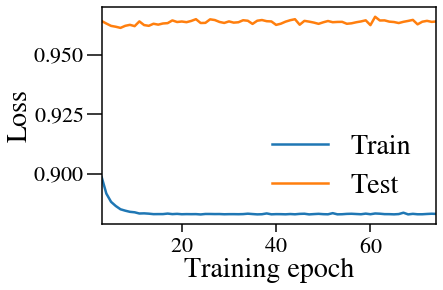

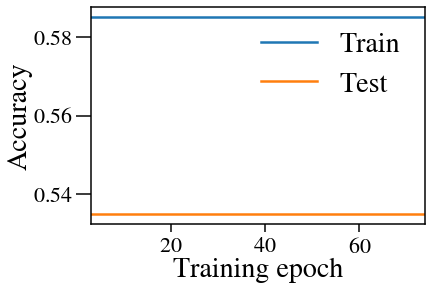

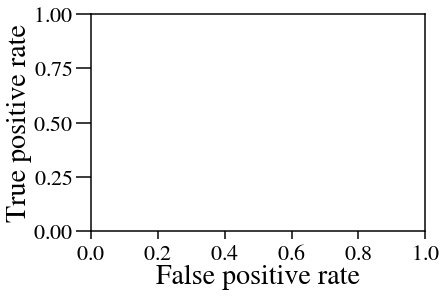

In [17]:
model, history = build_and_train_classifier(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[4]*12, 
        hidden_layer_kwargs=[dict(activation='tanh', kernel_initializer='random_normal')]*12,
#         hidden_layers=[keras.layers.Dense(8, activation='tanh'), keras.layers.Dense(8, activation='relu')],
        clear=True, epochs=250, scale_inputs=False,
        loss='categorical_crossentropy', optimizer='adam')

plot_history(history, skip=3)
plot_roc_and_auc_oneclass([model], validateX, validateY)

## What if I add more layers, change up the activations, or don't scale the inputs?

#### Not scaling the input:

In [ ]:
model, history = build_and_train_classifier(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[8]*4, 
        hidden_layer_kwargs=[dict(activation='relu', kernel_initializer='random_normal')]*4,
        clear=True, epochs=250, scale_inputs=False)

plot_history(history, skip=3)

So this does slightly better actually!

#### 

In [ ]:
nhidden = 8
model2, history2 = build_and_train_classifier(
    trainX, trainY, testX, testY, 
    hidden_layer_neurons=[24]*nhidden,
    hidden_layer_kwargs=[dict(activation='relu', kernel_initializer='random_normal')]*nhidden,
    dropout_every=2, clear=True)


In [ ]:
nhidden = 16
model2, history2 = build_and_train_classifier(
    trainX, trainY, testX, testY, 
    hidden_layer_neurons=[64]*nhidden,
    hidden_layer_kwargs=[dict(activation='relu', kernel_initializer='random_normal')]*nhidden,
    dropout_every=2, dropout_rate=0.25, clear=True)


#### Let's try training on advanced stats from the first couple years:

In [ ]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(
    yearly_df=yearly_df, player_df=player_df,
    training_columns=['true_shooting_percent', 'vorp', 'total_box_plus_minus', 'player_efficiency_rating'], 
    target_columns=['is_superstar', 'is_star', 'is_bust'],
    years_to_train_on=1, frac_train=0.9)

In [ ]:
model3, history3 = build_and_train_classifier(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[12, 12, 12],
        hidden_layer_kwargs=[dict(activation='relu', kernel_initializer='random_normal')]*3,
        clear=True, batch_size=32)